## Analyzing single states

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

from scipy.stats import gaussian_kde

import sys
sys.path.append('../local/bin/')
from sygno.nodes_position import _get_xcoord
from sygno.states_signed_networkx import draw_signed_networkx

In [5]:
dataset_folder = '../dataset/'
mmb = pd.read_csv('../dataset/HSall_members.csv')
pc = pd.read_csv('../dataset/HSall_parties.csv')

In [6]:
house_congress_path = '../dataset/download_votes_merged/'
senate_congress_path = '../dataset/download_votes_merged_senate/'

______________________________

#### Retrieve a dynamics for each state

In [33]:
# Test
test_congress = pd.read_csv(house_congress_path + 'congress_087.csv')
test_congress
test_congress['state_abbrev'] = test_congress['icpsr'].map(members2state_dic)
test_congress['district_code'] = test_congress['icpsr'].map(members2district_dic)
test_congress['party_name'] = test_congress['icpsr'].map(members_party_dict)

test_congress_TEST = test_congress[test_congress['state_abbrev'] == 'OR']

In [34]:
test_congress_TEST

,bill_number,id,description,chamber,date,vote_desc,vote_result,congress,rollnumber,Peltzman,Clausen,name,party_short_name,icpsr,vote,state_abbrev,district_code,party_name
324,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
325,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"ULLMAN, Albert Conrad",Democrat,9551,Abs,OR,2.0,[Democrat]
326,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"GREEN, Edith Starrett",Democrat,3775,Yea,OR,3.0,[Democrat]
327,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"DURNO, Edwin Russell",Republican,10515,Yea,OR,4.0,[Republican]
761,HR11222,RH0870161,H.R. 11222. FOOD AND AGRICULTURE ACT OF 1962....,House,1962-06-21,NaN,NaN,87,161,Regulation Special Interest,Agriculture,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104043,NaN,RH0870001,ELECTION OF SPEAKER. RAYBURN VERSUS HALLECK. ...,House,1961-01-03,NaN,NaN,87,1,Internal Organization,Miscellaneous Policy,"DURNO, Edwin Russell",Republican,10515,Nay,OR,4.0,[Republican]
104477,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
104478,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"ULLMAN, Albert Conrad",Democrat,9551,Yea,OR,2.0,[Democrat]
104479,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"GREEN, Edith Starrett",Democrat,3775,Yea,OR,3.0,[Democrat]


List of the states

In [11]:
states_list = list(set(members2state_dic.values()))

In [20]:
cong_state_perc_list = []

for csv in tqdm(glob.glob(house_congress_path + '/*.csv')):
    curr_congress = pd.read_csv(csv)
    curr_congress['state'] = curr_congress['icpsr'].map(members2state_dic)
    curr_congress['district_code'] = curr_congress['icpsr'].map(members2district_dic)
    curr_congress['party_name'] = curr_congress['icpsr'].map(members_party_dict)

    for state in states_list:
        curr_state = curr_congress[curr_congress['state'] == state]
        total_votes = len(curr_state)

        
        if total_votes > 0:

            dem_n = 0
            rep_n = 0
            other_n = 0

            for member in curr_state['icpsr'].unique():
                # the 'party_name' column is a list of elements. We need to count the number of times each element appears in the list
                dem_n += curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Democrat')
                rep_n += curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Republican')
                # other in case it is not democrat or republican
                other_n += len(curr_state[curr_state['icpsr'] == member]['party_name'].values[0]) - curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Democrat') - curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Republican')

            tot = dem_n + rep_n + other_n

            cong_state_perc_list.append({
                'congress' : int(re.findall(r'\d+', csv)[0]),
                'state' : state,
                'total_votes' : tot,
                'total_dem' : dem_n,
                'total_rep' : rep_n,
                'total_other' : other_n,
                'perc_dem' : dem_n / tot,
                'perc_rep' : rep_n / tot,
                'perc_other' : other_n / tot
            })
        else:
            cong_state_perc_list.append({
                'congress' : int(re.findall(r'\d+', csv)[0]),
                'state' : state,
                'total_votes' : 0,
                'total_dem' : 0,
                'total_rep' : 0,
                'total_other' : 0,
                'perc_dem' : 0,
                'perc_rep' : 0,
                'perc_other' : 0
            })


cong_state_perc = pd.DataFrame(cong_state_perc_list)



  0%|          | 0/41 [00:00<?, ?it/s]

  5%|▍         | 2/41 [00:05<02:00,  3.10s/it]/tmp/ipykernel_30814/1651910213.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  curr_congress = pd.read_csv(csv)
100%|██████████| 41/41 [02:28<00:00,  3.62s/it]


In [21]:
cong_state_perc

,congress,state,total_votes,total_dem,total_rep,total_other,perc_dem,perc_rep,perc_other
0,87,DC,0,0,0,0,0.000000,0.000000,0.0
1,87,LA,9,9,0,0,1.000000,0.000000,0.0
2,87,IN,12,4,8,0,0.333333,0.666667,0.0
3,87,NJ,14,6,8,0,0.428571,0.571429,0.0
4,87,CO,4,2,2,0,0.500000,0.500000,0.0
...,...,...,...,...,...,...,...,...,...
2332,84,PA,31,15,16,0,0.483871,0.516129,0.0
2333,84,AK,0,0,0,0,0.000000,0.000000,0.0
2334,84,NE,4,0,4,0,0.000000,1.000000,0.0
2335,84,ND,2,0,2,0,0.000000,1.000000,0.0


_________________________________________________________________________________________________________________________________

### Check the dynamics of polarization for each state

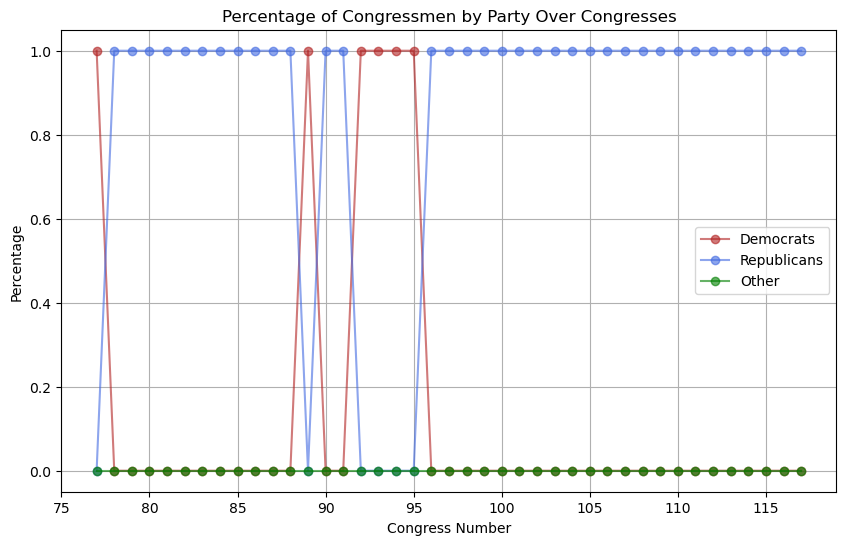

In [51]:
cong_state_perc_single_state = cong_state_perc[cong_state_perc['state'] == 'WY']

# Sort the DataFrame by the 'congress' column
cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

# Plotting
plt.figure(figsize=(10, 6))

transparency = 0.6

plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_dem'], label='Democrats', marker='o', alpha=transparency, color='firebrick')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_rep'], label='Republicans', marker='o', alpha=transparency, color='royalblue')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_other'], label='Other', marker='o', alpha=transparency, color='green')

plt.title('Percentage of Congressmen by Party Over Congresses')
plt.xlabel('Congress Number')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


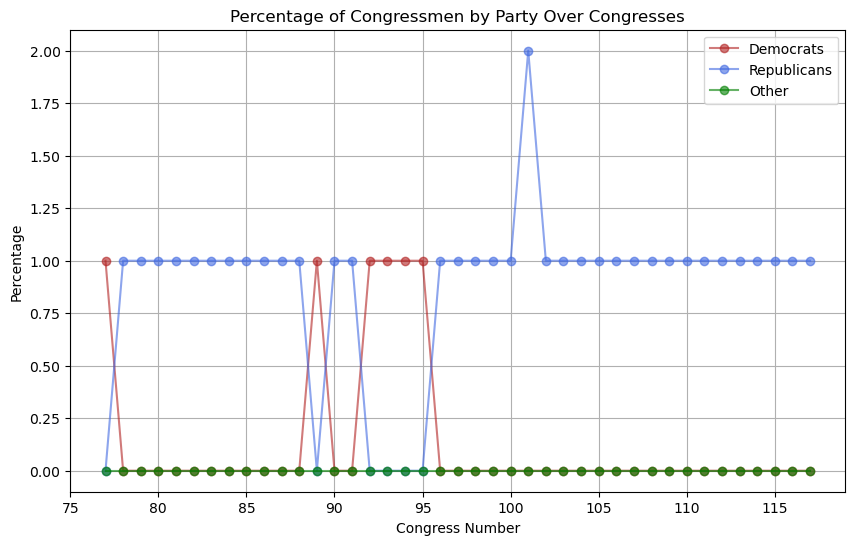

In [52]:
# Sort the DataFrame by the 'congress' column
cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

# Plotting
plt.figure(figsize=(10, 6))

transparency = 0.6

plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_dem'], label='Democrats', marker='o', alpha=transparency, color='firebrick')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_rep'], label='Republicans', marker='o', alpha=transparency, color='royalblue')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_other'], label='Other', marker='o', alpha=transparency, color='green')

plt.title('Percentage of Congressmen by Party Over Congresses')
plt.xlabel('Congress Number')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()